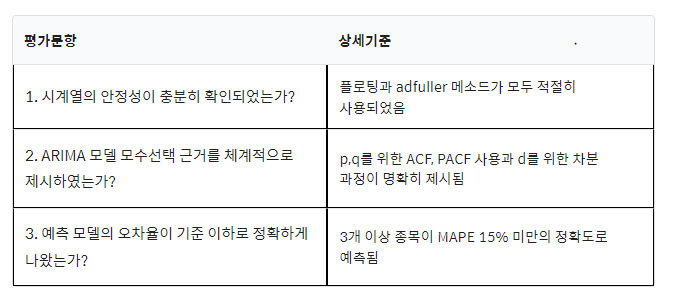

오늘은 ARIMA를 통해 시계열 데이터를 에측하는 과정을 진행해보았습니다. 
주제는 현대차에 대한 주식 시세 예측입니다. 2016-2019로 총 4년치의 데이터를 학습시켜보았습니다.













In [1]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error

import math
import warnings
warnings.filterwarnings('ignore') #경고 무시

import os
import glob
from matplotlib.pylab import rcParams

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

# STEP 1 : 시계열 데이터 준비
- 칼럼 종류: Date, Open, High, Low, Close, Adj Close, Volume
- 날짜별로 시작가(Open), 최고가(High), 최저가(Low), 종가(Close), 수정종가(Adj Close), 거래량(Volume)이 저장되어 있는 것을 확인할 수 있습니다.
- 우리는 종가(Close)만 사용하겠습니다. (주식 시장은 정해진 시간 동안만 거래가 가능합니다. 종가란 하루의 장이 마감하였을 때의 가격입니다.)

## 현대차 2016-2019 4년치

In [2]:
dataset_filepath = glob.glob('{}/aiffel/stock_prediction/data/*Movis*.csv'.format(os.getenv('HOME')))
print(dataset_filepath)
df = pd.read_csv(dataset_filepath[0], index_col='date', parse_dates=True)

rcParams['figure.figsize'] = 13, 6  # matlab 차트의 기본 크기를 13, 6로 지정해 줍니다.


# del ts
ts = df['close']

print()
print(type(ts))

ts.head()



['/aiffel/aiffel/stock_prediction/data/005380_HyundaeMovis.csv']

<class 'pandas.core.series.Series'>


date
2016-01-04    144000.0
2016-01-05    143500.0
2016-01-06    140000.0
2016-01-07    137500.0
2016-01-08    136500.0
Name: close, dtype: float64

# step 2 : 각종 전처리 수행

- 결측치 처리
- 로그 변환

## 결측치 처리

In [3]:
ts = ts.interpolate(method='time')
ts[ts.isna()]  # Time Series에서 결측치가 있는 부분만 Series로 출력합니다. 

Series([], Name: close, dtype: float64)

## 로그변환

In [4]:
ts_log = np.log(ts)


# STEP 3 : 시계열 안정성 분석

- 정성적 그래프 분석
- 정량적 Augmented Dicky-Fuller Test
- 시계열 분해(Time Series Decomposition)
- Residual 안정성 확인



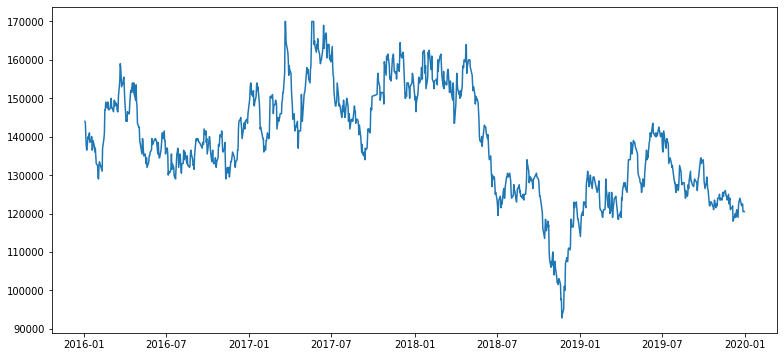

In [5]:
ts = df['close']
plt.plot(ts)

## 정성적 그래프 분석

In [6]:
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

     # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)


In [7]:
def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메서드를 호출합니다.
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메서드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

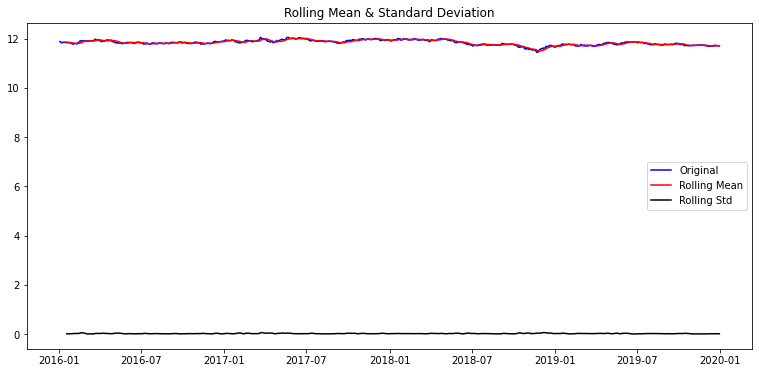

Results of Dickey-Fuller Test:
Test Statistic                  -2.445632
p-value                          0.129269
#Lags Used                       0.000000
Number of Observations Used    978.000000
Critical Value (1%)             -3.437054
Critical Value (5%)             -2.864500
Critical Value (10%)            -2.568346
dtype: float64


In [8]:
# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=12)

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 


# 결론 !¶
p-value의 값 0.129269이므로, 0.05보다 큰 값입니다. 분명히 귀무가설을 기각할 이유가 없습니다. 따라서 시계열은 실제로 비정상적입니다.

In [9]:

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

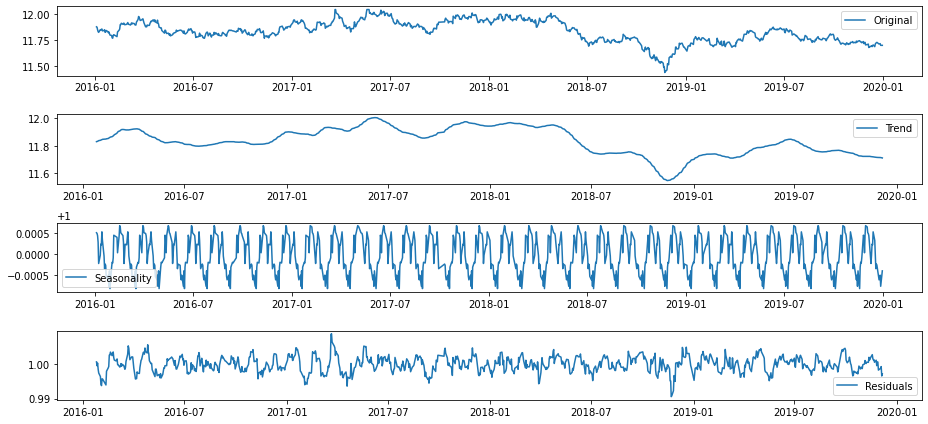

In [10]:
plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

## residual 안정성 확인

In [11]:
# 예시코드

residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -1.114851e+01
p-value                        2.984072e-20
#Lags Used                     1.100000e+01
Number of Observations Used    9.370000e+02
Critical Value (1%)           -3.437348e+00
Critical Value (5%)           -2.864630e+00
Critical Value (10%)          -2.568415e+00
dtype: float64


# 결론 !¶
p-value의 값 2.984072e-20 = 0.00000000000000000003이므로, 0.05보다 매우작은값입니다. 즉 p-value의 값이 유의 수준 0.05보다 매우 작으므로 귀무 가설을 기각하고 계열이 정상적이라고 간주할 수 있습니다.

# 로그변환 만으론 부족, Moving average 제거

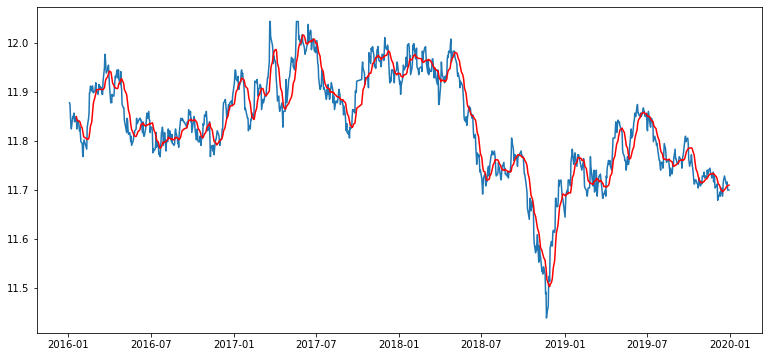

In [12]:
moving_avg = ts_log.rolling(window=12).mean()  # moving average구하기 
plt.plot(ts_log)
plt.plot(moving_avg, color='red')

In [13]:
ts_log_moving_avg = ts_log - moving_avg # 변화량 제거
ts_log_moving_avg.head(15)

date
2016-01-04         NaN
2016-01-05         NaN
2016-01-06         NaN
2016-01-07         NaN
2016-01-08         NaN
2016-01-11         NaN
2016-01-12         NaN
2016-01-13         NaN
2016-01-14         NaN
2016-01-15         NaN
2016-01-18         NaN
2016-01-19    0.000109
2016-01-20   -0.020751
2016-01-21   -0.013232
2016-01-22    0.001858
Name: close, dtype: float64

In [14]:
# 결측치 제거

ts_log_moving_avg.dropna(inplace=True)
ts_log_moving_avg.head(15)

date
2016-01-19    0.000109
2016-01-20   -0.020751
2016-01-21   -0.013232
2016-01-22    0.001858
2016-01-25   -0.008992
2016-01-26   -0.019655
2016-01-27   -0.010524
2016-01-28   -0.022498
2016-01-29   -0.032852
2016-02-01   -0.031437
2016-02-02   -0.048739
2016-02-03   -0.046386
2016-02-04   -0.015027
2016-02-05   -0.005657
2016-02-11   -0.020829
Name: close, dtype: float64

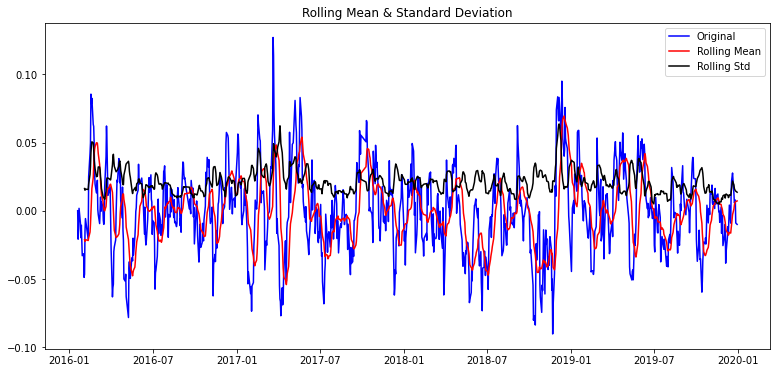

In [15]:
plot_rolling_statistics(ts_log_moving_avg)

In [16]:
augmented_dickey_fuller_test(ts_log_moving_avg)

Results of Dickey-Fuller Test:
Test Statistic                -9.608700e+00
p-value                        1.836371e-16
#Lags Used                     5.000000e+00
Number of Observations Used    9.620000e+02
Critical Value (1%)           -3.437166e+00
Critical Value (5%)           -2.864549e+00
Critical Value (10%)          -2.568372e+00
dtype: float64


p-value의 값이  1.628699e-15 = 0.0000000000000016287로 유의미하게 작아졌습니다. 이제 시계열 값으로 사용이 가능할듯합니다!

# STEP 4 : 학습, 테스트 데이터셋 생성

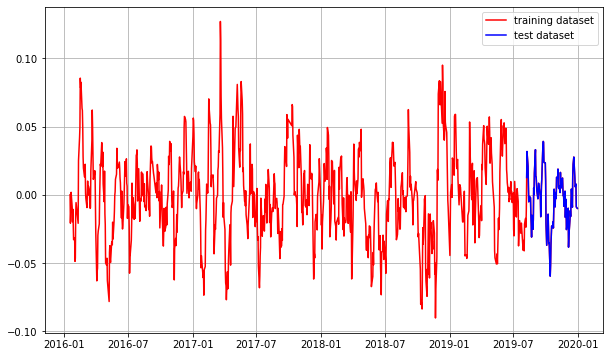

In [17]:
train_data, test_data = ts_log_moving_avg[:int(len(ts_log_moving_avg)*0.9)], ts_log_moving_avg[int(len(ts_log_moving_avg)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log_moving_avg, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log_moving_avg를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

# STEP 5 : 적정 ARIMA 모수 찾기
- ACF, PACF 그려보기 -> p,q 구하기
- 차분 안정성 확인 -> d 구하기

## ACF, PACF 그려보기 - p, q 구하기

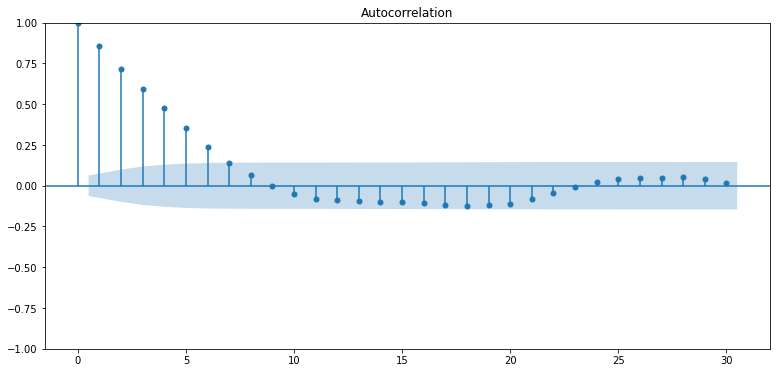

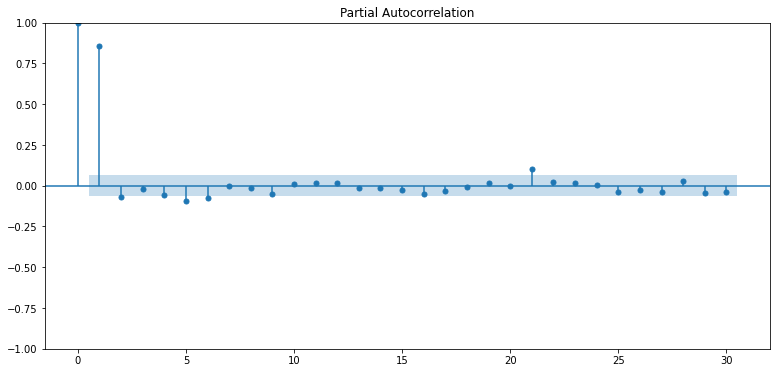

In [18]:
plot_acf(ts_log_moving_avg)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log_moving_avg)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

## 차분 안정성 확인 - d 구하기

Results of Dickey-Fuller Test:
Test Statistic                 -31.491499
p-value                          0.000000
#Lags Used                       0.000000
Number of Observations Used    977.000000
Critical Value (1%)             -3.437061
Critical Value (5%)             -2.864503
Critical Value (10%)            -2.568348
dtype: float64


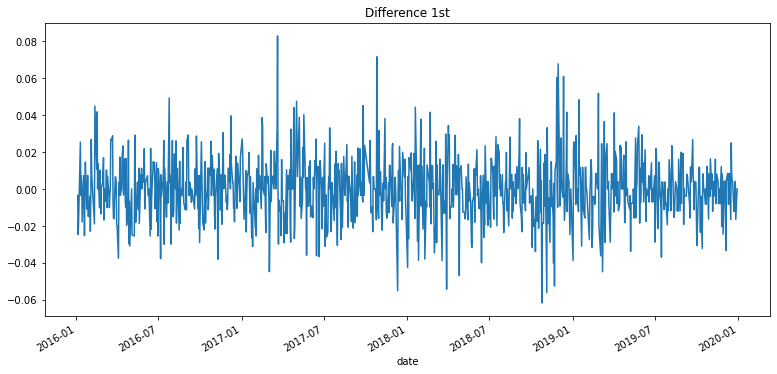

In [19]:
# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')


augmented_dickey_fuller_test(diff_1)

Results of Dickey-Fuller Test:
Test Statistic                -1.131280e+01
p-value                        1.227156e-20
#Lags Used                     2.200000e+01
Number of Observations Used    9.540000e+02
Critical Value (1%)           -3.437223e+00
Critical Value (5%)           -2.864574e+00
Critical Value (10%)          -2.568386e+00
dtype: float64


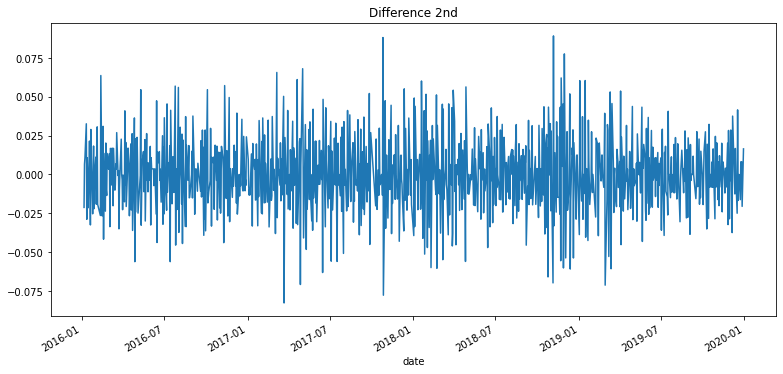

In [20]:
# 혹시 필요한 경우 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

# STEP 6 : ARIMA 모델 훈련과 테스트

- ARIMA 모델 빌드와 훈련
- 모델 테스트 및 플로팅
- 최종 예측 모델 정확도 측정(MAPE)
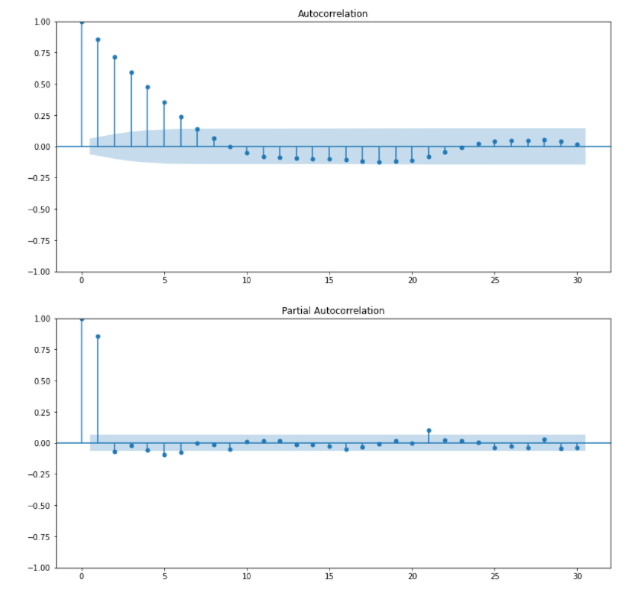


## (p, d, q) = 1, 0, 0

1번 노트북 네이버에서 시도했을 때, p,q의 값이 작았을 때가 더 효과적이었고, p + q < 2, p * q는 0인 조건을 만족할 때가 더 안정적이었습니다. 그래서 p = 1, q = 0값을 시도해볼것입니다.

현대차 역시 네이버와 유사하게 d값에 대한 1, 2차미분값이 0이었습니다. 그래서 네이버의 경험상 d = 1일때 더 결과가 좋았으므로 d = 1로 시도해볼것입니다.

In [21]:
# Build Model
model = ARIMA(train_data, order=(1, 0, 0)) 
fitted_m = model.fit() 

print(fitted_m.summary())

                               SARIMAX Results                                
Dep. Variable:                  close   No. Observations:                  871
Model:                 ARIMA(2, 0, 1)   Log Likelihood                2349.576
Date:                Wed, 16 Feb 2022   AIC                          -4689.152
Time:                        08:11:46   BIC                          -4665.303
Sample:                             0   HQIC                         -4680.027
                                - 871                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0006      0.004     -0.160      0.873      -0.008       0.007
ar.L1          1.2666      0.390      3.249      0.001       0.503       2.031
ar.L2         -0.3671      0.332     -1.105      0.2

In [22]:
# fitted_m.plot_predict()

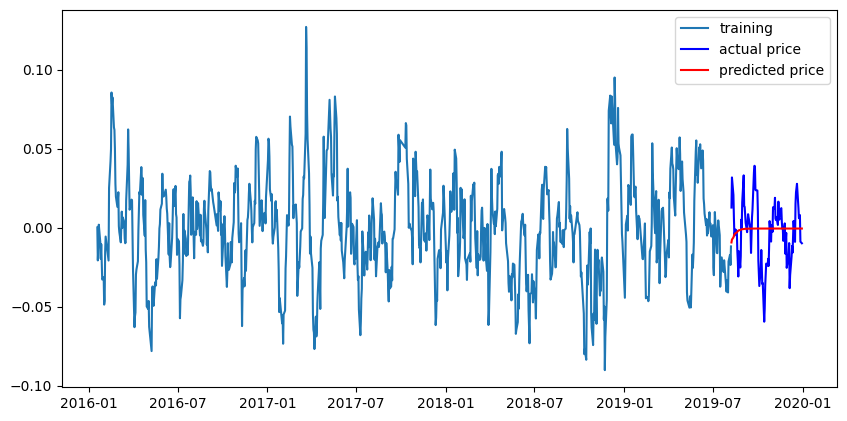

In [23]:
# Forecast : 결과가 fc에 담깁니다. 
fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

In [24]:
mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  0.0003924858185687958
MAE:  0.015719134690959376
RMSE:  0.019811254845889893
MAPE: 1.58%


MAPE값이 1.58로 꽤 안정적이라 따로 다른 실험을 진행하진 않았습니다.